## Embeddings et visualisation

### Importation des bibliothèques nécessaires

In [1]:
# Importation des bibliothèques pour le traitement des données, les modèles d'embeddings, et la visualisation
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

C:\Users\21354\AppData\Local\Temp\ipykernel_8492\2347506916.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Chargement des données

In [2]:
# Chemins vers les fichiers de données et le modèle GloVe
data_path = "Data\cleaned_data\dataset_with_tokens.csv"
glove_model_path = "embeddings\glove.6B.100d.txt"

df = pd.read_csv(data_path)  
df.head(10)

,text,label_encoded,tokens
0,drive to 'save' festive holidays efforts are b...,0,drive save festive holiday effort protect work...
1,brown hits back in blair rift row gordon brown...,0,brown hit back blair rift row gordon brown cri...
2,holmes is hit by hamstring injury kelly holmes...,1,holmes hit hamstring injury kelly holmes force...
3,the future in your pocket if you are a geek or...,2,future pocket geek gadget fan 12 month look go...
4,o'sullivan could run in worlds sonia o'sulliva...,1,run world sonia indicate participate month wor...
5,argonaut founder rebuilds empire jez san the m...,2,argonaut founder rebuild empire jez san man be...
6,'errors' doomed first dome sale the initial at...,0,error doom first dome sale initial attempt sel...
7,parry firm over gerrard listen to the full int...,1,parry firm gerrard listen full interview sport...
8,aragones angered by racism fine spain coach lu...,1,aragone anger racism fine spain coach luis ara...
9,online games play with politics after bubbling...,2,online game play politic bubble time online ga...


### Préparation des données

In [3]:
# Préparation des listes de tokens et des labels pour l'entraînement
# Extraction des tokens et des labels
sentences = df["tokens"].apply(lambda x: x.split()).tolist()

labels = df["label_encoded"].values

### Entraînement du modèle Word2Vec

In [4]:
# Création et entraînement du modèle Word2Vec avec les paramètres suivants:
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,     
    window=5,
    min_count=2,
    workers=4,
    sg=1                 
)

### Chargement du modèle GloVe

In [5]:
# Fonction pour charger les embeddings GloVe depuis un fichier texte
def load_glove(path):
    embeddings = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

glove = load_glove(glove_model_path)
EMB_DIM = 100

### Définition de la fonction d'embedding de document

In [6]:
# Fonction qui calcule l'embedding moyen d'un document basé sur ses tokens
def document_embedding(tokens, model, dim):
    vectors = []
    vectors.extend(model[token] for token in tokens if token in model)
    return np.zeros(dim) if not vectors else np.mean(vectors, axis=0)

### Calcul des embeddings des documents

In [7]:
# Calcul des matrices d'embeddings pour tous les documents
# GloVe embeddings
X_glove = np.array([
    document_embedding(tokens, glove, 100)
    for tokens in sentences
])

# Word2Vec embeddings
X_w2v = np.array([
    document_embedding(tokens, w2v_model.wv, 100)
    for tokens in sentences
])

### Réduction de dimension avec PCA

In [8]:
# Application de PCA pour réduire la dimension à 2
pca_glove = PCA(n_components=2)
X_glove_pca = pca_glove.fit_transform(X_glove)

pca_w2v = PCA(n_components=2)
X_w2v_pca = pca_w2v.fit_transform(X_w2v)

### Réduction de dimension avec t-SNE

In [9]:
# Application de t-SNE pour réduire la dimension à 2
tsne_glove = TSNE(n_components=2, perplexity=30, random_state=42)
X_glove_tsne = tsne_glove.fit_transform(X_glove)

tsne_w2v = TSNE(n_components=2, perplexity=30, random_state=42)
X_w2v_tsne = tsne_w2v.fit_transform(X_w2v)

### Définition de la fonction de visualisation

In [10]:
# Fonction pour tracer les embeddings en 2D avec couleurs par classe
label_names = {0: "Sport", 1: "Tech", 2: "Politics"}
colors = ["red", "blue", "green"]

def plot_embeddings(X, labels, title):
    plt.figure(figsize=(8,6))
    for label in set(labels):
        idx = labels == label
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            label=label_names[label],
            alpha=0.7
        )
    plt.legend()
    plt.title(title)
    plt.show()

### Visualisations des embeddings

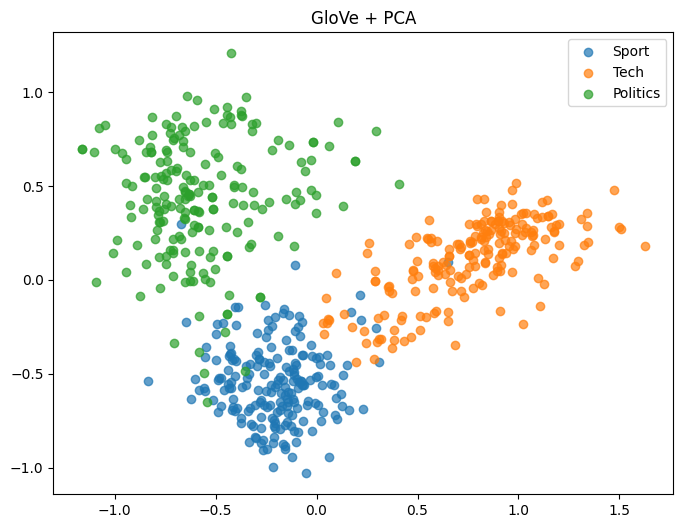

In [11]:
plot_embeddings(X_glove_pca, labels, "GloVe + PCA")

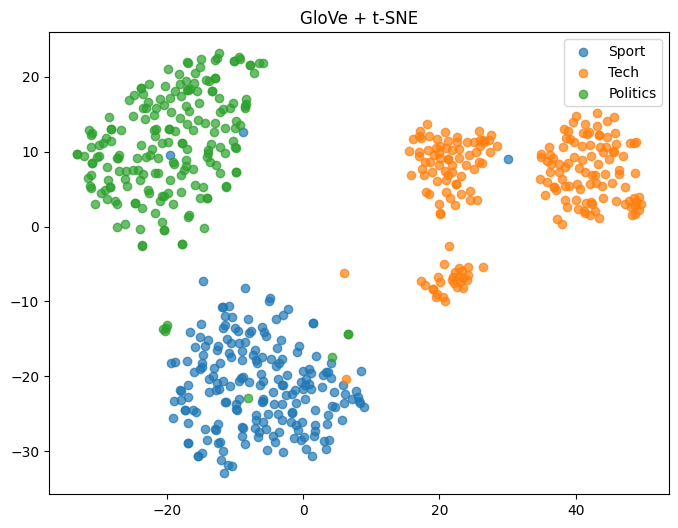

In [12]:
plot_embeddings(X_glove_tsne, labels, "GloVe + t-SNE")

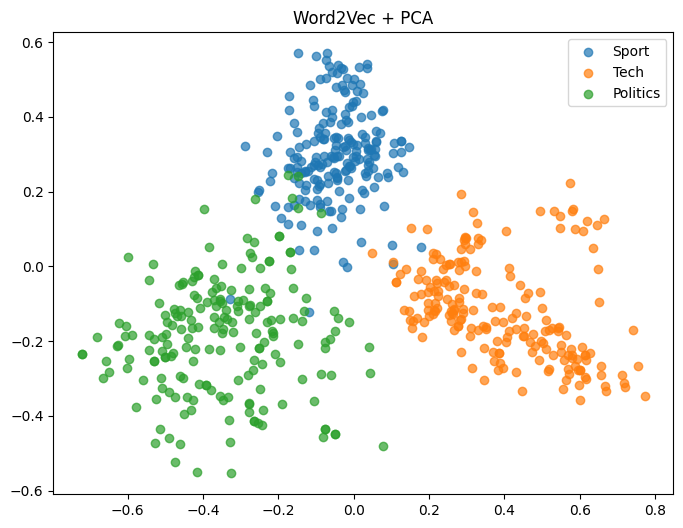

In [13]:
plot_embeddings(X_w2v_pca, labels, "Word2Vec + PCA")

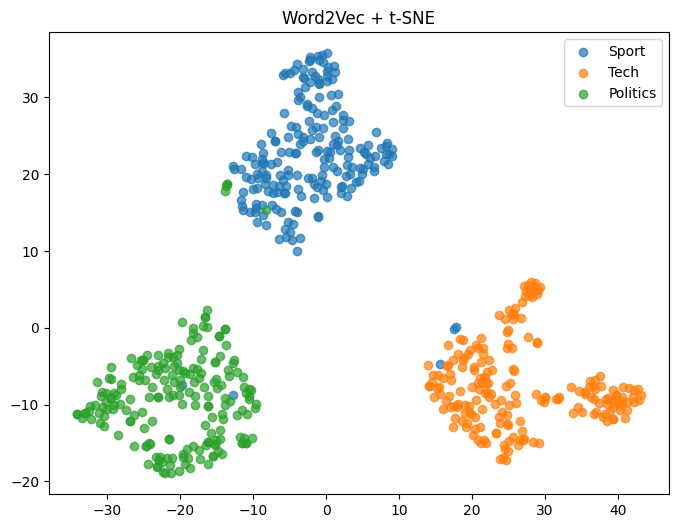

In [14]:
plot_embeddings(X_w2v_tsne, labels, "Word2Vec + t-SNE")

### Création d'embeddings de phrases (moyenne pondérée)

In [15]:
# Importation supplémentaire pour TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Fonction pour calculer l'embedding pondéré d'un document
def document_embedding_weighted(tokens, model, tfidf_weights, dim):
    vectors = []
    weights = []
    for token in tokens:
        if token in model and token in tfidf_weights:
            vectors.append(model[token])
            weights.append(tfidf_weights[token])
    if len(vectors) == 0:
        return np.zeros(dim)
    # Calcul de la moyenne pondérée
    weighted_sum = np.sum([w * v for w, v in zip(weights, vectors)], axis=0)
    total_weight = sum(weights)
    if total_weight == 0:
        return np.zeros(dim)
    return weighted_sum / total_weight

# Préparation des textes pour TF-IDF (rejoindre les tokens en chaînes)
texts = [' '.join(sent) for sent in sentences]

# Calcul des poids TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calcul des embeddings pondérés pour GloVe
X_glove_weighted = []
for i, tokens in enumerate(sentences):
    tfidf_weights = {feature_names[j]: tfidf_matrix[i, j] for j in range(len(feature_names)) if tfidf_matrix[i, j] > 0}
    emb = document_embedding_weighted(tokens, glove, tfidf_weights, 100)
    X_glove_weighted.append(emb)
X_glove_weighted = np.array(X_glove_weighted)

# Calcul des embeddings pondérés pour Word2Vec
X_w2v_weighted = []
for i, tokens in enumerate(sentences):
    tfidf_weights = {feature_names[j]: tfidf_matrix[i, j] for j in range(len(feature_names)) if tfidf_matrix[i, j] > 0}
    emb = document_embedding_weighted(tokens, w2v_model.wv, tfidf_weights, 100)
    X_w2v_weighted.append(emb)
X_w2v_weighted = np.array(X_w2v_weighted)

# Exemple d'affichage pour vérifier
print("Exemple d'embedding pondéré GloVe pour le premier document :", X_glove_weighted[0][:5])  # Premiers 5 éléments

Exemple d'embedding pondéré GloVe pour le premier document : [-0.18200688  0.25890246  0.00326578 -0.21291953 -0.07576604]


### Visualisation des embeddings pondérés

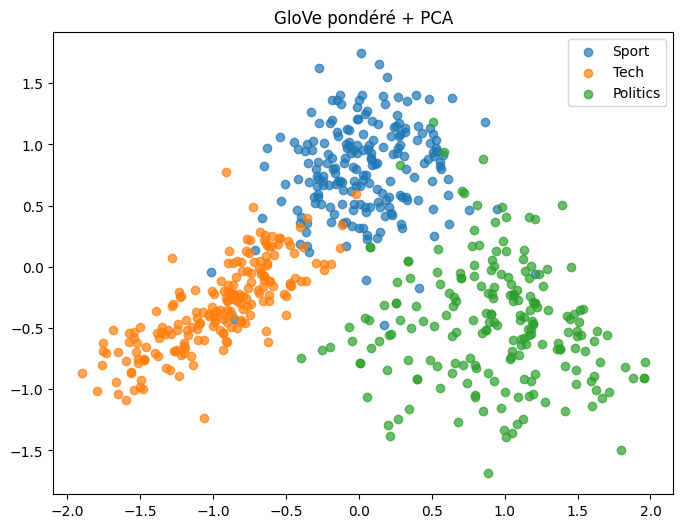

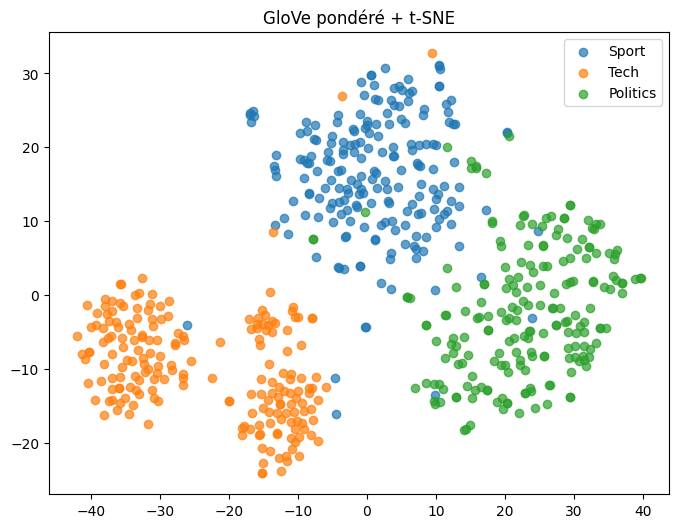

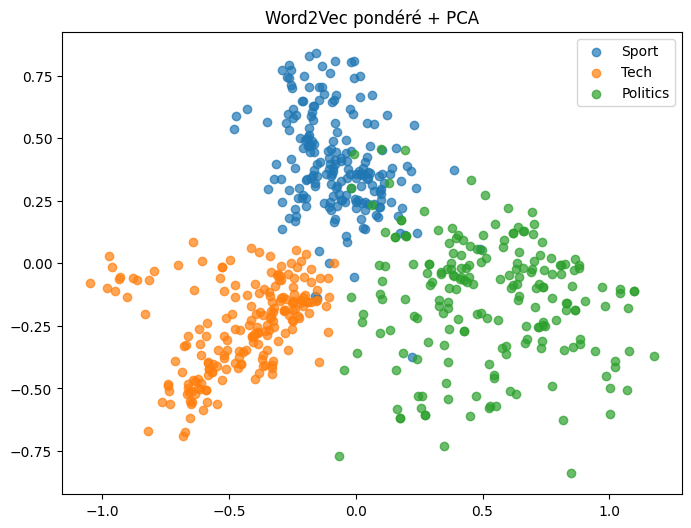

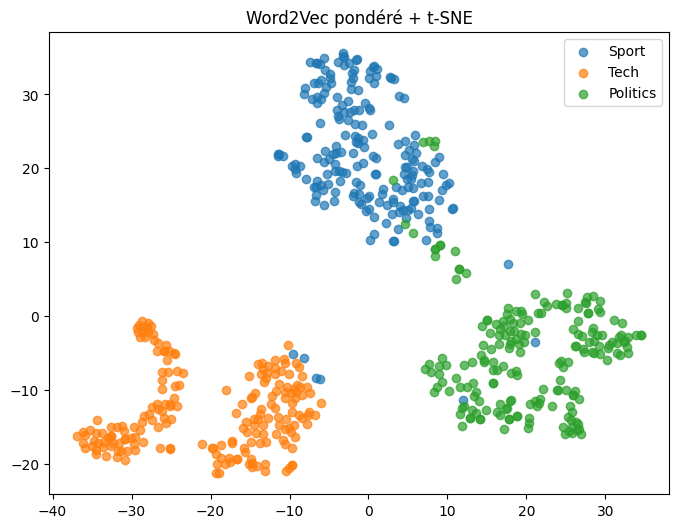

In [16]:
# Réduction de dimension pour les embeddings pondérés avec PCA
pca_glove_weighted = PCA(n_components=2)
X_glove_weighted_pca = pca_glove_weighted.fit_transform(X_glove_weighted)

pca_w2v_weighted = PCA(n_components=2)
X_w2v_weighted_pca = pca_w2v_weighted.fit_transform(X_w2v_weighted)

# Réduction de dimension pour les embeddings pondérés avec t-SNE
tsne_glove_weighted = TSNE(n_components=2, perplexity=30, random_state=42)
X_glove_weighted_tsne = tsne_glove_weighted.fit_transform(X_glove_weighted)

tsne_w2v_weighted = TSNE(n_components=2, perplexity=30, random_state=42)
X_w2v_weighted_tsne = tsne_w2v_weighted.fit_transform(X_w2v_weighted)

# Visualisations des embeddings pondérés
plot_embeddings(X_glove_weighted_pca, labels, "GloVe pondéré + PCA")
plot_embeddings(X_glove_weighted_tsne, labels, "GloVe pondéré + t-SNE")
plot_embeddings(X_w2v_weighted_pca, labels, "Word2Vec pondéré + PCA")
plot_embeddings(X_w2v_weighted_tsne, labels, "Word2Vec pondéré + t-SNE")